# This notebook:
### Demonstration of ghost trace identification in NIRISS WFSS data.

## Output products:
- Segmentation image for identified ghosts.

Users will be able to refer to this segmap to distinguish wfss ghosts in their input WFSS image.

### Ghosts will be identified based on a priori knowledge of 
    1. GAP (currently derived with CV3 data),
    2. source positions in the direct image (ie. source catalog of the direct image)

This notebook demonstrates identification of ghosts in the direct image too.

### Ghost id script is available at:
https://github.com/spacetelescope/niriss_ghost

In [1]:
import os
import sys
import h5py
import string
import numpy as np
import scipy
from scipy.stats import binned_statistic_2d
import math
import glob

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,5)
params={'legend.fontsize':'18','axes.labelsize':'18',
        'axes.titlesize':'18','xtick.labelsize':'18',
        'ytick.labelsize':'18','lines.linewidth':2,
        'axes.linewidth':2,'animation.html': 'html5',
        'figure.figsize':(10,10)}
plt.rcParams.update(params)
plt.rcParams.update({'figure.max_open_warning': 0})
import matplotlib.patches as patches

import astropy
from astropy.visualization import simple_norm
from astropy.io import fits,ascii
from astropy.table import Table
from astropy import units as u
import asdf

import jwst
from jwst import datamodels
from jwst import assign_wcs
from jwst.assign_wcs import assign_wcs_step

import grismconf

# For photutils;
import astropy.wcs as wcs
from photutils import Background2D, MedianBackground, detect_sources, deblend_sources, SourceCatalog, source_properties
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.convolution import Gaussian2DKernel
f_deblend = True                


# From https://github.com/spacetelescope/niriss_ghost
import niriss_ghost
import niriss_ghost.detect_ghost_image2
from niriss_ghost.utils import get_corners,get_gap_wfss,get_ghost_wfss


In [2]:
print('pipeline:',jwst.__version__)
print('astropy:',astropy.__version__)
print('numpy:',np.__version__)
print('scipy:',scipy.__version__)
print('asdf:',asdf.__version__)
print('niriss_ghost',niriss_ghost.__version__)


pipeline: 1.3.2.dev9+g48ea1c7a
astropy: 4.2
numpy: 1.20.1
scipy: 1.6.1
asdf: 2.7.2
niriss_ghost 1.0.0


## 0. Preparation

In [3]:
# Target filter;
filts = ['F090W','F115W','F140M','F150W','F158M','F200W']

# Output directory for the products from this script;
DIR_OUT = './output/'


### Get ghost positions in direct image

In [23]:
DIR_DAT = './wfss_ghost_example/'

# Ex.1 with R grism.
# ID00054 corresponds to the direc image of the target file, 00053.
#id_direct = '00054'
#id_wfss = '00053'

# Ex.2 with C grism.
# ID00049 corresponds to the direc image of the target file, 00057.
id_direct = '00049'
id_wfss = '00057'

# The source catalog, cat_direct, was obtained by running photutils on direct image;
file_direct = '%s/jw01090001001_01101_%s_nis_cal.fits'%(DIR_DAT,id_direct)
cat_direct = '%s/jw01090001001_01101_%s_nis_cat_man.ecsv'%(DIR_DAT,id_direct)
ratename = '%s/jw01090001001_01101_%s_nis_rate.fits'%(DIR_DAT,id_wfss)

# DIR
if not os.path.exists(DIR_DAT):
    os.mkdir(DIR_DAT)

# Download files;
if not os.path.exists(file_direct):
    os.system('wget -O %s https://stsci.box.com/shared/static/61w92ncwoqbi1vsm30zcdhokj8wmmyfk.fits'%file_direct)
if not os.path.exists(cat_direct):
    os.system('wget -O %s https://stsci.box.com/shared/static/55fq9759vo3g6j8r089g4xfjkdo6gw4g.ecsv'%cat_direct)
if not os.path.exists(ratename):
    os.system('wget -O %s https://stsci.box.com/shared/static/9w2zy00pypnacrlsa3erkew0mp5ebgnj.fits'%ratename)


--2021-12-15 11:37:41--  https://stsci.box.com/shared/static/61w92ncwoqbi1vsm30zcdhokj8wmmyfk.fits
Resolving stsci.box.com (stsci.box.com)... 107.152.29.197
Connecting to stsci.box.com (stsci.box.com)|107.152.29.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/61w92ncwoqbi1vsm30zcdhokj8wmmyfk.fits [following]
--2021-12-15 11:37:42--  https://stsci.box.com/public/static/61w92ncwoqbi1vsm30zcdhokj8wmmyfk.fits
Reusing existing connection to stsci.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://stsci.app.box.com/public/static/61w92ncwoqbi1vsm30zcdhokj8wmmyfk.fits [following]
--2021-12-15 11:37:42--  https://stsci.app.box.com/public/static/61w92ncwoqbi1vsm30zcdhokj8wmmyfk.fits
Resolving stsci.app.box.com (stsci.app.box.com)... 107.152.29.201
Connecting to stsci.app.box.com (stsci.app.box.com)|107.152.29.201|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: ht

  2450K .......... .......... .......... .......... ..........  2%  395K 5m57s
  2500K .......... .......... .......... .......... ..........  2%  213K 6m0s
  2550K .......... .......... .......... .......... ..........  2%  164K 6m6s
  2600K .......... .......... .......... .......... ..........  2%  234K 6m8s
  2650K .......... .......... .......... .......... ..........  2%  230K 6m10s
  2700K .......... .......... .......... .......... ..........  2%  313K 6m9s
  2750K .......... .......... .......... .......... ..........  2%  116K 6m20s
  2800K .......... .......... .......... .......... ..........  2%  385K 6m18s
  2850K .......... .......... .......... .......... ..........  2%  255K 6m19s
  2900K .......... .......... .......... .......... ..........  2%  367K 6m18s
  2950K .......... .......... .......... .......... ..........  2%  298K 6m17s
  3000K .......... .......... .......... .......... ..........  2%  165K 6m22s
  3050K .......... .......... .......... .......... ....

  7650K .......... .......... .......... .......... ..........  6%  123K 6m30s
  7700K .......... .......... .......... .......... ..........  6% 96.4K 6m35s
  7750K .......... .......... .......... .......... ..........  6%  209K 6m35s
  7800K .......... .......... .......... .......... ..........  6%  282K 6m35s
  7850K .......... .......... .......... .......... ..........  6%  314K 6m35s
  7900K .......... .......... .......... .......... ..........  6%  237K 6m35s
  7950K .......... .......... .......... .......... ..........  6%  328K 6m34s
  8000K .......... .......... .......... .......... ..........  7%  410K 6m33s
  8050K .......... .......... .......... .......... ..........  7%  118K 6m36s
  8100K .......... .......... .......... .......... ..........  7%  427K 6m35s
  8150K .......... .......... .......... .......... ..........  7%  133K 6m37s
  8200K .......... .......... .......... .......... ..........  7%  488K 6m36s
  8250K .......... .......... .......... .......... 

 12900K .......... .......... .......... .......... .......... 11%  439K 6m50s
 12950K .......... .......... .......... .......... .......... 11%  104K 6m52s
 13000K .......... .......... .......... .......... .......... 11%  292K 6m51s
 13050K .......... .......... .......... .......... .......... 11%  476K 6m50s
 13100K .......... .......... .......... .......... .......... 11%  532K 6m49s
 13150K .......... .......... .......... .......... .......... 11%  408K 6m48s
 13200K .......... .......... .......... .......... .......... 11%  195K 6m49s
 13250K .......... .......... .......... .......... .......... 11%  297K 6m48s
 13300K .......... .......... .......... .......... .......... 11%  335K 6m48s
 13350K .......... .......... .......... .......... .......... 11%  287K 6m47s
 13400K .......... .......... .......... .......... .......... 11%  376K 6m47s
 13450K .......... .......... .......... .......... .......... 11%  131K 6m48s
 13500K .......... .......... .......... .......... 

 18100K .......... .......... .......... .......... .......... 15%  157K 8m6s
 18150K .......... .......... .......... .......... .......... 15% 84.7K 8m7s
 18200K .......... .......... .......... .......... .......... 15% 39.9K 8m12s
 18250K .......... .......... .......... .......... .......... 15% 23.0K 8m22s
 18300K .......... .......... .......... .......... .......... 15%  112K 8m23s
 18350K .......... .......... .......... .......... .......... 16%  201K 8m23s
 18400K .......... .......... .......... .......... .......... 16%  180K 8m22s
 18450K .......... .......... .......... .......... .......... 16%  218K 8m22s
 18500K .......... .......... .......... .......... .......... 16%  216K 8m22s
 18550K .......... .......... .......... .......... .......... 16%  105K 8m22s
 18600K .......... .......... .......... .......... .......... 16% 79.5K 8m24s
 18650K .......... .......... .......... .......... .......... 16% 95.8K 8m25s
 18700K .......... .......... .......... .......... ..

 23350K .......... .......... .......... .......... .......... 20%  208K 10m51s
 23400K .......... .......... .......... .......... .......... 20%  364K 10m50s
 23450K .......... .......... .......... .......... .......... 20%  278K 10m49s
 23500K .......... .......... .......... .......... .......... 20%  472K 10m47s
 23550K .......... .......... .......... .......... .......... 20%  339K 10m46s
 23600K .......... .......... .......... .......... .......... 20%  427K 10m45s
 23650K .......... .......... .......... .......... .......... 20%  242K 10m44s
 23700K .......... .......... .......... .......... .......... 20%  274K 10m43s
 23750K .......... .......... .......... .......... .......... 20%  382K 10m42s
 23800K .......... .......... .......... .......... .......... 20%  283K 10m41s
 23850K .......... .......... .......... .......... .......... 20%  327K 10m40s
 23900K .......... .......... .......... .......... .......... 20%  332K 10m39s
 23950K .......... .......... ..........

 28500K .......... .......... .......... .......... .......... 24%  147K 9m57s
 28550K .......... .......... .......... .......... .......... 24%  303K 9m56s
 28600K .......... .......... .......... .......... .......... 24%  257K 9m55s
 28650K .......... .......... .......... .......... .......... 25%  125K 9m55s
 28700K .......... .......... .......... .......... .......... 25%  468K 9m54s
 28750K .......... .......... .......... .......... .......... 25%  345K 9m53s
 28800K .......... .......... .......... .......... .......... 25%  160K 9m52s
 28850K .......... .......... .......... .......... .......... 25%  504K 9m51s
 28900K .......... .......... .......... .......... .......... 25%  370K 9m50s
 28950K .......... .......... .......... .......... .......... 25%  198K 9m50s
 29000K .......... .......... .......... .......... .......... 25%  282K 9m49s
 29050K .......... .......... .......... .......... .......... 25%  309K 9m48s
 29100K .......... .......... .......... .......... 

 33700K .......... .......... .......... .......... .......... 29%  262K 8m58s
 33750K .......... .......... .......... .......... .......... 29%  293K 8m57s
 33800K .......... .......... .......... .......... .......... 29%  356K 8m56s
 33850K .......... .......... .......... .......... .......... 29%  301K 8m56s
 33900K .......... .......... .......... .......... .......... 29%  487K 8m55s
 33950K .......... .......... .......... .......... .......... 29%  133K 8m55s
 34000K .......... .......... .......... .......... .......... 29%  494K 8m54s
 34050K .......... .......... .......... .......... .......... 29%  201K 8m53s
 34100K .......... .......... .......... .......... .......... 29%  338K 8m52s
 34150K .......... .......... .......... .......... .......... 29%  238K 8m52s
 34200K .......... .......... .......... .......... .......... 29%  488K 8m51s
 34250K .......... .......... .......... .......... .......... 29%  391K 8m50s
 34300K .......... .......... .......... .......... 

 38900K .......... .......... .......... .......... .......... 33%  418K 7m56s
 38950K .......... .......... .......... .......... .......... 33%  253K 7m56s
 39000K .......... .......... .......... .......... .......... 34%  236K 7m55s
 39050K .......... .......... .......... .......... .......... 34% 1.03M 7m54s
 39100K .......... .......... .......... .......... .......... 34%  200K 7m54s
 39150K .......... .......... .......... .......... .......... 34%  443K 7m53s
 39200K .......... .......... .......... .......... .......... 34%  352K 7m53s
 39250K .......... .......... .......... .......... .......... 34%  447K 7m52s
 39300K .......... .......... .......... .......... .......... 34%  508K 7m51s
 39350K .......... .......... .......... .......... .......... 34%  435K 7m50s
 39400K .......... .......... .......... .......... .......... 34%  351K 7m50s
 39450K .......... .......... .......... .......... .......... 34%  200K 7m49s
 39500K .......... .......... .......... .......... 

 44100K .......... .......... .......... .......... .......... 38%  225K 7m3s
 44150K .......... .......... .......... .......... .......... 38%  306K 7m3s
 44200K .......... .......... .......... .......... .......... 38%  296K 7m2s
 44250K .......... .......... .......... .......... .......... 38%  197K 7m2s
 44300K .......... .......... .......... .......... .......... 38%  285K 7m1s
 44350K .......... .......... .......... .......... .......... 38%  304K 7m1s
 44400K .......... .......... .......... .......... .......... 38%  295K 7m0s
 44450K .......... .......... .......... .......... .......... 38%  322K 7m0s
 44500K .......... .......... .......... .......... .......... 38%  244K 6m59s
 44550K .......... .......... .......... .......... .......... 38%  264K 6m59s
 44600K .......... .......... .......... .......... .......... 38%  340K 6m58s
 44650K .......... .......... .......... .......... .......... 38%  193K 6m58s
 44700K .......... .......... .......... .......... ........

 49300K .......... .......... .......... .......... .......... 43%  449K 6m16s
 49350K .......... .......... .......... .......... .......... 43%  593K 6m16s
 49400K .......... .......... .......... .......... .......... 43%  325K 6m15s
 49450K .......... .......... .......... .......... .......... 43%  496K 6m15s
 49500K .......... .......... .......... .......... .......... 43%  353K 6m14s
 49550K .......... .......... .......... .......... .......... 43%  497K 6m14s
 49600K .......... .......... .......... .......... .......... 43%  548K 6m13s
 49650K .......... .......... .......... .......... .......... 43%  541K 6m13s
 49700K .......... .......... .......... .......... .......... 43%  231K 6m12s
 49750K .......... .......... .......... .......... .......... 43%  743K 6m12s
 49800K .......... .......... .......... .......... .......... 43%  366K 6m11s
 49850K .......... .......... .......... .......... .......... 43%  252K 6m11s
 49900K .......... .......... .......... .......... 

 54500K .......... .......... .......... .......... .......... 47%  227K 5m36s
 54550K .......... .......... .......... .......... .......... 47%  358K 5m36s
 54600K .......... .......... .......... .......... .......... 47%  235K 5m35s
 54650K .......... .......... .......... .......... .......... 47%  333K 5m35s
 54700K .......... .......... .......... .......... .......... 47% 57.1K 5m35s
 54750K .......... .......... .......... .......... .......... 47%  262K 5m35s
 54800K .......... .......... .......... .......... .......... 47%  500K 5m34s
 54850K .......... .......... .......... .......... .......... 47%  117K 5m34s
 54900K .......... .......... .......... .......... .......... 47%  370K 5m34s
 54950K .......... .......... .......... .......... .......... 47%  267K 5m33s
 55000K .......... .......... .......... .......... .......... 47%  328K 5m33s
 55050K .......... .......... .......... .......... .......... 48%  144K 5m33s
 55100K .......... .......... .......... .......... 

 59700K .......... .......... .......... .......... .......... 52%  306K 5m2s
 59750K .......... .......... .......... .......... .......... 52%  248K 5m2s
 59800K .......... .......... .......... .......... .......... 52%  496K 5m2s
 59850K .......... .......... .......... .......... .......... 52%  112K 5m2s
 59900K .......... .......... .......... .......... .......... 52%  193K 5m1s
 59950K .......... .......... .......... .......... .......... 52%  615K 5m1s
 60000K .......... .......... .......... .......... .......... 52%  158K 5m1s
 60050K .......... .......... .......... .......... .......... 52% 29.3K 5m2s
 60100K .......... .......... .......... .......... .......... 52%  160K 5m1s
 60150K .......... .......... .......... .......... .......... 52%  202K 5m1s
 60200K .......... .......... .......... .......... .......... 52%  196K 5m1s
 60250K .......... .......... .......... .......... .......... 52%  336K 5m0s
 60300K .......... .......... .......... .......... .......... 5

 64900K .......... .......... .......... .......... .......... 56%  491K 4m28s
 64950K .......... .......... .......... .......... .......... 56%  212K 4m27s
 65000K .......... .......... .......... .......... .......... 56%  315K 4m27s
 65050K .......... .......... .......... .......... .......... 56%  245K 4m27s
 65100K .......... .......... .......... .......... .......... 56%  227K 4m26s
 65150K .......... .......... .......... .......... .......... 56%  209K 4m26s
 65200K .......... .......... .......... .......... .......... 56%  436K 4m26s
 65250K .......... .......... .......... .......... .......... 56%  115K 4m25s
 65300K .......... .......... .......... .......... .......... 56%  376K 4m25s
 65350K .......... .......... .......... .......... .......... 56%  335K 4m25s
 65400K .......... .......... .......... .......... .......... 57%  446K 4m24s
 65450K .......... .......... .......... .......... .......... 57%  248K 4m24s
 65500K .......... .......... .......... .......... 

 70100K .......... .......... .......... .......... .......... 61%  449K 3m56s
 70150K .......... .......... .......... .......... .......... 61%  222K 3m56s
 70200K .......... .......... .......... .......... .......... 61% 61.2K 3m56s
 70250K .......... .......... .......... .......... .......... 61% 93.5K 3m56s
 70300K .......... .......... .......... .......... .......... 61%  515K 3m55s
 70350K .......... .......... .......... .......... .......... 61%  161K 3m55s
 70400K .......... .......... .......... .......... .......... 61%  327K 3m55s
 70450K .......... .......... .......... .......... .......... 61%  270K 3m54s
 70500K .......... .......... .......... .......... .......... 61%  221K 3m54s
 70550K .......... .......... .......... .......... .......... 61%  205K 3m54s
 70600K .......... .......... .......... .......... .......... 61%  397K 3m53s
 70650K .......... .......... .......... .......... .......... 61% 92.0K 3m53s
 70700K .......... .......... .......... .......... 

 75250K .......... .......... .......... .......... .......... 65%  223K 3m28s
 75300K .......... .......... .......... .......... .......... 65%  348K 3m28s
 75350K .......... .......... .......... .......... .......... 65%  245K 3m27s
 75400K .......... .......... .......... .......... .......... 65%  491K 3m27s
 75450K .......... .......... .......... .......... .......... 65%  378K 3m27s
 75500K .......... .......... .......... .......... .......... 65%  305K 3m26s
 75550K .......... .......... .......... .......... .......... 65%  320K 3m26s
 75600K .......... .......... .......... .......... .......... 65%  941K 3m26s
 75650K .......... .......... .......... .......... .......... 65%  287K 3m25s
 75700K .......... .......... .......... .......... .......... 66%  248K 3m25s
 75750K .......... .......... .......... .......... .......... 66%  542K 3m25s
 75800K .......... .......... .......... .......... .......... 66%  677K 3m24s
 75850K .......... .......... .......... .......... 

 80450K .......... .......... .......... .......... .......... 70%  171K 2m56s
 80500K .......... .......... .......... .......... .......... 70%  367K 2m55s
 80550K .......... .......... .......... .......... .......... 70%  245K 2m55s
 80600K .......... .......... .......... .......... .......... 70%  196K 2m55s
 80650K .......... .......... .......... .......... .......... 70%  253K 2m55s
 80700K .......... .......... .......... .......... .......... 70%  348K 2m54s
 80750K .......... .......... .......... .......... .......... 70%  280K 2m54s
 80800K .......... .......... .......... .......... .......... 70%  373K 2m54s
 80850K .......... .......... .......... .......... .......... 70%  222K 2m53s
 80900K .......... .......... .......... .......... .......... 70%  324K 2m53s
 80950K .......... .......... .......... .......... .......... 70%  481K 2m53s
 81000K .......... .......... .......... .......... .......... 70%  202K 2m53s
 81050K .......... .......... .......... .......... 

 85650K .......... .......... .......... .......... .......... 74%  177K 2m28s
 85700K .......... .......... .......... .......... .......... 74%  345K 2m27s
 85750K .......... .......... .......... .......... .......... 74%  525K 2m27s
 85800K .......... .......... .......... .......... .......... 74%  448K 2m27s
 85850K .......... .......... .......... .......... .......... 74%  427K 2m26s
 85900K .......... .......... .......... .......... .......... 74%  367K 2m26s
 85950K .......... .......... .......... .......... .......... 74%  473K 2m26s
 86000K .......... .......... .......... .......... .......... 74%  414K 2m26s
 86050K .......... .......... .......... .......... .......... 75%  131K 2m25s
 86100K .......... .......... .......... .......... .......... 75% 59.5M 2m25s
 86150K .......... .......... .......... .......... .......... 75%  197K 2m25s
 86200K .......... .......... .......... .......... .......... 75%  340K 2m24s
 86250K .......... .......... .......... .......... 

 90850K .......... .......... .......... .......... .......... 79%  278K 2m0s
 90900K .......... .......... .......... .......... .......... 79%  232K 1m59s
 90950K .......... .......... .......... .......... .......... 79%  426K 1m59s
 91000K .......... .......... .......... .......... .......... 79%  244K 1m59s
 91050K .......... .......... .......... .......... .......... 79%  335K 1m58s
 91100K .......... .......... .......... .......... .......... 79%  280K 1m58s
 91150K .......... .......... .......... .......... .......... 79%  217K 1m58s
 91200K .......... .......... .......... .......... .......... 79%  451K 1m58s
 91250K .......... .......... .......... .......... .......... 79%  179K 1m57s
 91300K .......... .......... .......... .......... .......... 79%  375K 1m57s
 91350K .......... .......... .......... .......... .......... 79%  334K 1m57s
 91400K .......... .......... .......... .......... .......... 79%  167K 1m57s
 91450K .......... .......... .......... .......... .

 96100K .......... .......... .......... .......... .......... 83%  280K 92s
 96150K .......... .......... .......... .......... .......... 83%  496K 92s
 96200K .......... .......... .......... .......... .......... 83%  593K 92s
 96250K .......... .......... .......... .......... .......... 83%  361K 91s
 96300K .......... .......... .......... .......... .......... 83%  151K 91s
 96350K .......... .......... .......... .......... .......... 83%  397K 91s
 96400K .......... .......... .......... .......... .......... 84%  352K 91s
 96450K .......... .......... .......... .......... .......... 84%  192K 90s
 96500K .......... .......... .......... .......... .......... 84%  514K 90s
 96550K .......... .......... .......... .......... .......... 84% 47.5K 90s
 96600K .......... .......... .......... .......... .......... 84% 26.6K 90s
 96650K .......... .......... .......... .......... .......... 84%  210K 90s
 96700K .......... .......... .......... .......... .......... 84%  105K 90s

101400K .......... .......... .......... .......... .......... 88%  578K 66s
101450K .......... .......... .......... .......... .......... 88%  239K 66s
101500K .......... .......... .......... .......... .......... 88%  233K 65s
101550K .......... .......... .......... .......... .......... 88%  349K 65s
101600K .......... .......... .......... .......... .......... 88%  177K 65s
101650K .......... .......... .......... .......... .......... 88%  436K 65s
101700K .......... .......... .......... .......... .......... 88%  237K 64s
101750K .......... .......... .......... .......... .......... 88%  523K 64s
101800K .......... .......... .......... .......... .......... 88%  340K 64s
101850K .......... .......... .......... .......... .......... 88%  339K 63s
101900K .......... .......... .......... .......... .......... 88%  257K 63s
101950K .......... .......... .......... .......... .......... 88%  259K 63s
102000K .......... .......... .......... .......... .......... 88%  501K 63s

106700K .......... .......... .......... .......... .......... 93%  352K 40s
106750K .......... .......... .......... .......... .......... 93%  243K 39s
106800K .......... .......... .......... .......... .......... 93%  263K 39s
106850K .......... .......... .......... .......... .......... 93%  361K 39s
106900K .......... .......... .......... .......... .......... 93%  235K 39s
106950K .......... .......... .......... .......... .......... 93%  204K 38s
107000K .......... .......... .......... .......... .......... 93%  315K 38s
107050K .......... .......... .......... .......... .......... 93%  320K 38s
107100K .......... .......... .......... .......... .......... 93%  280K 38s
107150K .......... .......... .......... .......... .......... 93%  227K 37s
107200K .......... .......... .......... .......... .......... 93%  233K 37s
107250K .......... .......... .......... .......... .......... 93%  182K 37s
107300K .......... .......... .......... .......... .......... 93%  221K 37s

112050K .......... .......... .......... .......... .......... 97%  166K 14s
112100K .......... .......... .......... .......... .......... 97% 70.2K 13s
112150K .......... .......... .......... .......... .......... 97% 24.7K 13s
112200K .......... .......... .......... .......... .......... 97%  179K 13s
112250K .......... .......... .......... .......... .......... 97% 40.3K 13s
112300K .......... .......... .......... .......... .......... 97%  217K 12s
112350K .......... .......... .......... .......... .......... 97% 80.2K 12s
112400K .......... .......... .......... .......... .......... 97%  128K 12s
112450K .......... .......... .......... .......... .......... 98% 79.0K 12s
112500K .......... .......... .......... .......... .......... 98% 48.2K 11s
112550K .......... .......... .......... .......... .......... 98%  270K 11s
112600K .......... .......... .......... .......... .......... 98%  197K 11s
112650K .......... .......... .......... .......... .......... 98% 44.3K 11s

Resolving public.boxcloud.com (public.boxcloud.com)... 107.152.26.200
Connecting to public.boxcloud.com (public.boxcloud.com)|107.152.26.200|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9942 (9.7K) [application/octet-stream]
Saving to: ‘./wfss_ghost_example//jw01090001001_01101_00049_nis_cat_man.ecsv’

     0K .........                                             100% 62.4K=0.2s

2021-12-15 11:48:06 (62.4 KB/s) - ‘./wfss_ghost_example//jw01090001001_01101_00049_nis_cat_man.ecsv’ saved [9942/9942]



### Run ghost id script on the direct image;

In [24]:
# Run;
niriss_ghost.detect_ghost_image2.run([file_direct], [cat_direct], keyword_id='label', keyword_flux='segment_flux',
                                    DIR_OUT=DIR_OUT)
# Equivalently;
# $python ~/GitHub/niriss_ghost/niriss_ghost/detect_ghost_image2.py ../../NIS-016_Aug21_full/reduced/jw01090001001_01101_00049_nis_cal.fits ../../NIS-016_Aug21_full/reduced/jw01090001001_01101_00049_nis_cat_man.ecsv 


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Running ghost detection script
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Target coordinates are: 81.0818057202483 -70.08363513442043
Catalog saved to : ./output//ghost_detected_cat_jw01090001001_01101_00049_nis_cal.txt
Using gap summary file: /Users/tmorishita/anaconda3/envs/mirage_py3.8/lib/python3.8/site-packages/niriss_ghost-1.0.0-py3.8.egg/niriss_ghost//niriss_ghost_gap_summary.txt
Plot saved to : ./output//results_jw01090001001_01101_00049_nis_cal.png

Tweaking DQ array...
No segmtation map specified by --segmap. Guessing from the input image name...

Segmentation file (./wfss_ghost_example//jw01090001001_01101_00049_nis_cal_seg.fits) is missing. No DQ tweaking.

Successfully done! (1/1)



In [25]:
# Open the output ghost catalog from the command above;
file_cat = DIR_OUT+'ghost_detected_cat_jw01090001001_01101_%s_nis_cal.txt'%id_direct
fd_cat = ascii.read(file_cat)
print(file_cat)
print(fd_cat)

# Open source catalog of direct image;
# obtained either by image2 or manually running photutils.
# This is to get the source size, to predict the trace.
fd_src = ascii.read(cat_direct)
keyword_radius = 'semimajor_sigma' #'equivalent_radius'
equivalent_radius = fd_src[keyword_radius]


./output/ghost_detected_cat_jw01090001001_01101_00049_nis_cal.txt
 id     ra         dec          x       ...  id_src    ra_src     dec_src  
--- ---------- ----------- ------------ ... -------- ---------- -----------
  1 81.0634519  -70.090869  1361.989389 ...     25.0 81.0858615 -70.0792891
  2 81.0670622 -70.0885776 1296.1049384 ...     22.0  81.082279 -70.0815863
  3 81.0876028 -70.0886221        911.0 ...      nan        nan         nan
  4 81.0611338 -70.0878319 1407.8074066 ...      nan        nan         nan
  5 81.0638076 -70.0874298 1358.0029467 ... 100004.0 81.0855275 -70.0827451
  6 81.0833695 -70.0873001  991.3783098 ...      nan        nan         nan
  7 81.0867376 -70.0871142  928.3699955 ...      nan        nan         nan
  8 81.0904352 -70.0867764  859.2935849 ...      nan        nan         nan
...        ...         ...          ... ...      ...        ...         ...
 19 81.0899831 -70.0827526  870.8193259 ...      nan        nan         nan
 20 81.0822366 -70.082

### Run photutils on WFSS data, to get a segment map for all traces

2021-12-15 13:17:06,108 - stpipe - WARNING - /Users/tmorishita/anaconda3/envs/mirage_py3.8/lib/python3.8/site-packages/astropy/wcs/wcs.py:513: FITSFixedWarning: The WCS transformation has more axes (2) than the image it is associated with (0)
  warnings.warn(



Running photutils on ./wfss_ghost_example//jw01090001001_01101_00057_nis_rate.fits


2021-12-15 13:17:11,859 - stpipe - WARNING - /var/folders/vp/2t_8sndd16jcbrzf8jk3l97h0001jh/T/ipykernel_55651/2710934663.py:43: AstropyDeprecationWarning: The source_properties function is deprecated and may be removed in a future version.
        Use `~photutils.segmentation.SourceCatalog` instead.
  cat = source_properties(data-bkg.background, segm_deblend, wcs=imwcs, background=bkg.background, error=err)

2021-12-15 13:17:11,864 - stpipe - WARNING - /Users/tmorishita/anaconda3/envs/mirage_py3.8/lib/python3.8/site-packages/photutils/segmentation/properties.py:1894: AstropyDeprecationWarning: The SourceProperties class is deprecated and may be removed in a future version.
        Use `~photutils.segmentation.SourceCatalog` instead.
  sources_props.append(SourceProperties(

2021-12-15 13:17:11,895 - stpipe - WARNING - /Users/tmorishita/anaconda3/envs/mirage_py3.8/lib/python3.8/site-packages/photutils/segmentation/properties.py:1902: AstropyDeprecationWarning: The LegacySourceCatalog cl

Segment file saved to jw01090001001_01101_00057_nis_rate_seg.fits


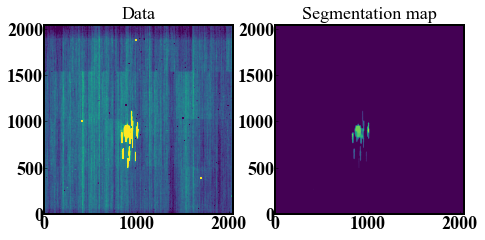

In [29]:

for infile in [ratename]:
    print('Running photutils on',infile)
    hdu = fits.open(infile)
    data = hdu[1].data
    imwcs = wcs.WCS(hdu[0].header, hdu)

    #weight = hdu[3].data
    weight = np.zeros(data.shape, 'float') + 1
    err = 1/np.sqrt(weight)

    fig = plt.figure(figsize=(7.,3.5))
    fig.subplots_adjust(top=.9, bottom=0.15,left=0.12,right=.96,hspace=0.2,wspace=0.2)
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    ax1.imshow(data,vmin=0,vmax=1)
    ax1.set_title('Data')


    # Measure background and set detection threshold
    bkg_estimator = MedianBackground()
    bkg = Background2D(data, (50, 50), filter_size=(3, 3), bkg_estimator=bkg_estimator)
    #threshold = bkg.background + (15. * bkg.background_rms)
    threshold = bkg.background + (2. * bkg.background_rms)

    # Before detection, smooth image with Gaussian FWHM = n pixels
    #sigma = 30.0 * gaussian_fwhm_to_sigma  
    sigma = 1.5 * gaussian_fwhm_to_sigma  
    #sigma = 2.5 * gaussian_fwhm_to_sigma  

    #kernel = Gaussian2DKernel(sigma, x_size=5, y_size=5)
    kernel = Gaussian2DKernel(sigma)#, x_size=5, y_size=5)
    kernel.normalize()

    # Detect and deblend
    segm_detect = detect_sources(data, threshold, npixels=20)#, filter_kernel=kernel)

    if f_deblend:
        segm_deblend = deblend_sources(data, segm_detect, npixels=20, filter_kernel=kernel, nlevels=32, contrast=0.001)
        segm_hdu = fits.PrimaryHDU(segm_deblend.data.astype(np.uint32), header=imwcs.to_header())
        # This causes some issue
        #cat = SourceCatalog(data-bkg.background, segm_deblend, wcs=imwcs, background=bkg.background, error=err)
        cat = source_properties(data-bkg.background, segm_deblend, wcs=imwcs, background=bkg.background, error=err)
    else:
        segm_hdu = fits.PrimaryHDU(segm_detect.data.astype(np.uint32), header=imwcs.to_header())
        # This causes some issue
        #cat = SourceCatalog(data-bkg.background, segm_detect, wcs=imwcs, background=bkg.background, error=err)
        cat = source_properties(data-bkg.background, segm_detect, wcs=imwcs, background=bkg.background, error=err)

    ax2.imshow(segm_hdu.data)#,vmin=0,vmax=10)
    ax2.set_title('Segmentation map')

    file_seg = infile.split('/')[-1].replace('.fits','_seg.fits')
    segm_hdu.writeto(file_seg, overwrite=True)
    print('Segment file saved to',file_seg)

    # Save cat;
    columns = ['label','xcentroid','ycentroid', 'source_sum', 'bbox_xmin', 'bbox_xmax', 'bbox_ymin', 'bbox_ymax']#,'sky_centroid','aper_bkg_flux','aper_bkg_flux_err',\
               #'aper30_flux','aper30_flux_err','aper50_flux','aper50_flux_err','aper70_flux','aper70_flux_err',\
               #,'aper30_abmag','aper30_abmag_err','aper50_abmag','aper50_abmag_err','aper70_abmag','aper70_abmag_err','aper_total_abmag','aper_total_abmag_err','aper30_vegamag','aper30_vegamag_err','aper50_vegamag','aper50_vegamag_err','aper70_vegamag','aper70_vegamag_err','aper_total_vegamag','aper_total_vegamag_err','CI_30_50','CI_50_70','CI_30_70','is_star','sharpness','roundness','nn_dist','nn_abmag','isophotal_flux','isophotal_flux_err','isophotal_abmag','isophotal_abmag_err','isophotal_vegamag','isophotal_vegamag_err','isophotal_area','semimajor_sigma','semiminor_sigma','ellipticity','orientation','sky_orientation','sky_bbox_ll','sky_bbox_ul','sky_bbox_lr','sky_bbox_ur']

    tbl = cat.to_table(columns=columns)
    tbl.write(infile.split('/')[-1].replace('.fits','_cat_man.ecsv'), format='ascii.ecsv', overwrite=True)


## 1. Tag each wfss segment to direct source ids

The following cell requires a segmention map of the dispersed trace, which was prepared above.

In [33]:
print('Your input WFSS image is %s'%ratename)
with fits.open(ratename) as seedfile:
    dispersed_seedC = seedfile[0].data # in e/sec

with fits.open(ratename) as seedfile:
    h = seedfile[0].header 
    filt = h["PUPIL"]
    grism = h["FILTER"][-1]
    print("Filter:",filt)
    print("Grism:",grism)

C = grismconf.Config("/ifs/jwst/wit/mirage_data/niriss/GRISM_NIRISS/NIRISS_{}_GR150{}.conf".format(filt,grism))


Your input WFSS image is ./wfss_ghost_example//jw01090001001_01101_00057_nis_rate.fits
Filter: F200W
Grism: R


Working on order: 0
Working on order: +1
Working on order: +2
Working on order: -1
src id seg map is saved to jw01090001001_01101_00057_nis_rate_src_seg.fits
ghost id seg map is saved to jw01090001001_01101_00057_nis_rate_gst_seg.fits


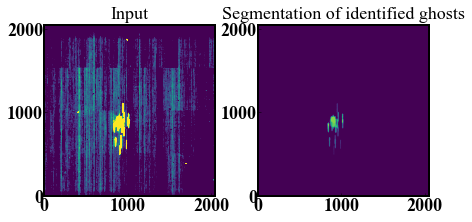

In [34]:
#from niriss_ghost.utils import get_ghost

orders = ['0','+1','+2','-1']
grating = 'GR150'
keyword_radius = 'semimajor_sigma' #'equivalent_radius'

infile = ratename

ids_seg = []
fig = plt.figure(figsize=(6.,4.))
fig.subplots_adjust(top=0.98, bottom=0.16, left=0.1, right=0.99, hspace=0.15, wspace=0.25)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# Sci map;
fd = fits.open(infile)[1].data#[ymin:ymax,xmin:xmax]
vmin,vmax = np.percentile(fd,[50,95])
ax1.imshow(fd, origin='lower', vmin=vmin, vmax=vmax)

# Seg map;
# This was prepared by running photoutils on the dispersed image.
# See above.
fdseg0 = fits.open(infile.split('/')[-1].replace('.fits','_seg.fits'))[0].data#[ymin:ymax,xmin:xmax]

for order in orders:
    print('Working on order: %s'%order)

    # Open catalog;
    # These (_src) are actually for ghost
    x_src = fd_cat['x'] #- 1 # -1 for python - DS9 conversion...
    y_src = fd_cat['y'] #- 1 # -1 for python - DS9 conversion...
    id_src = fd_cat['id']
    is_this_ghost = fd_cat['is_this_ghost']

    # Plot 2D;
    box_size = 40 

    for jj in range(len(id_src)):
        if is_this_ghost[jj] == 'True':
            continue

        src_size = fd_src[keyword_radius][jj].value * 2
        pos = [x_src[jj],y_src[jj]]

        xss,yss,xcen,ycen = get_corners(pos[0], pos[1], filt, C, ORD=order, delx=40, dely=40)
        x0s,x1s,y0s,y1s = xss[0],xss[-1],yss[0],yss[-1]

        if grism == 'C':
            ymin, ymax = int(np.min(yss)-box_size/2.), int(np.max(yss)+box_size/2.)
            xmin, xmax = int(np.min(xss)), int(np.max(xss))
        else:
            xmin, xmax = int(np.min(xss)-box_size/2.), int(np.max(xss)+box_size/2.)
            ymin, ymax = int(np.min(yss)), int(np.max(yss))

        # Boundary check:
        if ymin < 0:
            ymin = 0
        fdseg = fdseg0[ymin:ymax,xmin:xmax]

        ymid = (ymax+ymin)/2.
        xmid = (xmax+xmin)/2.

        # Check seg map. 
        # Check along cross-disp direction, at the peal position along disp direction.
        # ii : element along cross disp direction.
        if grism == 'C':
            for ixx,xx in enumerate(xss-xmin):
                for ii in range(int(yss[ixx]-src_size/2.-ymin),int(yss[ixx]+src_size/2.-ymin),1):
                    try:
                        id_trace = fdseg[ii,int(xx)]
                        if id_trace>0 and not id_trace in ids_seg:
                            ids_seg.append(id_trace)
                    except:
                        pass
        else:
            #ax2.plot(xss-src_size/2.-xmin, yss-ymin, linestyle='--', lw=1, color='r')
            for iyy,yy in enumerate(yss-ymin):
                for ii in range(int(xss[iyy]-src_size/2.-xmin),int(xss[iyy]+src_size/2.-xmin),1):
                    try:
                        id_trace = fdseg[int(yy),ii]
                        if id_trace>0 and not id_trace in ids_seg:
                            ids_seg.append(id_trace)
                    except:
                        pass

fdseg_src = np.zeros(fdseg0.shape, 'float')
fdseg_gst = fdseg0

for id_seg in ids_seg:
    con = np.where(fdseg0 == id_seg)
    fdseg_src[con] = id_seg
    fdseg0[con] = 0

ax1.set_title('Input')

ax2.imshow(fdseg_src, origin='lower')
ax2.set_title('Segmentation of identified ghosts')

file_out_src = infile.split('/')[-1].replace('.fits','_src_seg.fits')
file_out_gst = infile.split('/')[-1].replace('.fits','_gst_seg.fits')

hdu = fits.PrimaryHDU(fdseg_src)
hdu.writeto(file_out_src, overwrite=True)
print('src id seg map is saved to %s'%file_out_src)

hdu_gst = fits.PrimaryHDU(fdseg0)
hdu_gst.writeto(file_out_gst, overwrite=True)
print('ghost id seg map is saved to %s'%file_out_gst)

#print('Segmentation ids that are on the trace path are',ids_seg)
plt.savefig('src_mask.png')



### Each of the two plots show a segmentation map that tells from which source (in source catalog) each segment is originated. The one in left, src id seg map, is only for real sources (ie not flagged as ghosts) and right one, ghost id seg map, is only for ghosts.
<br>
Note: Detection of trace was based on the cell above; Tweak the detection threshould of photutils to configure for your input.
<br><br>

## 2. Check the result for individual sources, and tweak DQ array if you like.

#### Now you are ready to check if any particular trace is originated from ghost or not. The cell below will go through the ghost catalog and check the predicted position in WFSS to see if there is significant signal; if so, it flags the trace as ghost in DQ array (if f_dq_tweak is set to True).

#### In the following big cell, the input wfss image will be copied to a new file, as this cell updates the DQ array.

In [35]:
# For now, check one source; 

# ID of the source in direct image. Can select other source by looking at ghost id seg map.
idstart = 21 
idend = idstart+1


In [36]:
# Then apply the same method, with ids_seg from the cell above.
f_new_outfile = False #True
f_plot_src = True
verbose = False
f_dq_tweak = True # Tweak DQ array at the position of identified ghost trace.

# Plot 2D;
box_size = 40 
src_size = 10

infile = ratename
outfile = infile.split('/')[-1].replace('.fits','_gst.fits')
file_seg = infile.split('/')[-1].replace('.fits','_seg.fits')

# Make a copy;
if not os.path.exists(outfile):
    f_new_outfile = True
if f_new_outfile:
    os.system('cp %s %s'%(infile, outfile))

fd_data = fits.open(outfile)[1].data

# Loop over the source list;
for idtarg in range(idstart,idend,1):    
    try:
        iin = np.where(fd_cat['id'] == idtarg)[0][0]
        print('Current target: %d'%idtarg)
    except:
        print('ID%d not found. Skipping.'%idtarg)
        continue

    # Check if the source is a ghost;
    if fd_cat['is_this_ghost'][iin] == 'False': # careful, this element is string...
        print('This object is not ghost. Skipping.')
        continue
    
    # Fig;
    fig = plt.figure(figsize=(8.,2.2*len(orders)))
    fig.subplots_adjust(top=0.94, bottom=0.12, left=0.1, right=0.99, hspace=0.0, wspace=0.05)

    for oo,order in enumerate(orders):
        ax1 = fig.add_subplot(len(orders),3,3*oo+1)
        ax2 = fig.add_subplot(len(orders),3,3*oo+2)
        ax3 = fig.add_subplot(len(orders),3,3*oo+3)

        print('Working on order: %s'%order)
        ids_seg_gst = []

        # Open ghost-id catalog;
        x_gst = fd_cat['x'][iin] # -1 for python - DS9 conversion...
        y_gst = fd_cat['y'][iin] # -1 for python - DS9 conversion...
        id_gst = fd_cat['id'][iin]
        id_src = fd_cat['id_src'][iin]
        # Retrieve index for ghost
        iis = np.where(fd_cat['id'] == id_src)

        x_src = fd_cat['x'][iis] #- 1 # -1 for python - DS9 conversion...
        y_src = fd_cat['y'][iis] #- 1 # -1 for python - DS9 conversion...
        f_src = 1 #fd_cat['f_src_direct'][iin] 
        f_gst = 1 #fd_cat['f_gst_direct'][iin] 

        pos = [x_gst,y_gst]
        print('Target ghost positions in direct image are:',pos)

        xss,yss,xcen,ycen = get_corners(pos[0], pos[1], filt, C, ORD=order, delx=40, dely=40)
        x0s,x1s,y0s,y1s = xss[0],xss[-1],yss[0],yss[-1]

        if grism == 'C':
            ymin, ymax = int(np.min(yss)-box_size/2.), int(np.max(yss)+box_size/2.)
            xmin, xmax = int(np.min(xss)), int(np.max(xss))
        else:
            xmin, xmax = int(np.min(xss)-box_size/2.), int(np.max(xss)+box_size/2.)
            ymin, ymax = int(np.min(yss)), int(np.max(yss))

        ymid = (ymax+ymin)/2.
        xmid = (xmax+xmin)/2.
        print('Or, in wfss image:',[xmid,ymid])

        # This has to come after ymid, xmid
        if xmin<0:
            xmin = 0
        if ymin<0:
            ymin = 0
        if xmax>fd_data.shape[1]:
            xmax = fd_data.shape[1]
        if ymax>fd_data.shape[0]:
            ymax = fd_data.shape[0]
            
        # Open data;
        fd = fd_data[ymin:ymax,xmin:xmax]

        # Science extension;
        vmin,vmax = np.percentile(fd,[50,95])
        ax1.imshow(fd, origin='lower', vmin=vmin, vmax=vmax)
        ax1.plot(xss-xmin, yss-ymin, linestyle='--', lw=0.5, color='r')
        if grism == 'C':
            ax1.plot(xss-xmin, yss-src_size/2.-ymin, linestyle='--', lw=1, color='r')
            ax1.plot(xss-xmin, yss+src_size/2.-ymin, linestyle='--', lw=1, color='r')
        else:
            ax1.plot(xss-src_size/2.-xmin, yss-ymin, linestyle='--', lw=1, color='r')
            ax1.plot(xss+src_size/2.-xmin, yss-ymin, linestyle='--', lw=1, color='r')
        ax1.plot(xcen-xmin,ycen-ymin, 'x', ms=10)
        if oo == 0:
            ax1.set_title('science')
        ax1.set_ylabel('Order : %s'%order)

        # Seg extension;
        fdseg = fits.open(infile.split('/')[-1].replace('.fits','_seg.fits'))[0].data[ymin:ymax,xmin:xmax]
        ax2.imshow(fdseg, origin='lower')
        ax2.plot(xss-xmin, yss-ymin, linestyle='--', lw=0.5, color='r')
        if grism == 'C':
            ax2.plot(xss-xmin, yss-src_size/2.-ymin, linestyle='--', lw=1, color='r')
            ax2.plot(xss-xmin, yss+src_size/2.-ymin, linestyle='--', lw=1, color='r')
        else:
            ax2.plot(xss-src_size/2.-xmin, yss-ymin, linestyle='--', lw=1, color='r')
            ax2.plot(xss+src_size/2.-xmin, yss-ymin, linestyle='--', lw=1, color='r')
        ax2.plot(xcen-xmin, ycen-ymin, 'x', ms=10)
        if oo == 0:
            ax2.set_title('WFSS segmentation')


        # Check seg map. 
        # Check along cross-disp direction, at the peal position along disp direction.
        # ii : element along cross disp direction.
        if grism == 'C':
            for ixx,xx in enumerate(xss-xmin):
                for ii in range(int(yss[ixx]-src_size/2.-ymin),int(yss[ixx]+src_size/2.-ymin),1):
                    try:
                        id_trace = fdseg[ii,int(xx)]
                        if id_trace>0 and not id_trace in ids_seg_gst and not id_trace in ids_seg:
                            ids_seg_gst.append(id_trace)
                    except:
                        pass
        else:
            #ax2.plot(xss-src_size/2.-xmin, yss-ymin, linestyle='--', lw=1, color='r')
            for iyy,yy in enumerate(yss-ymin):
                for ii in range(int(xss[iyy]-src_size/2.-xmin),int(xss[iyy]+src_size/2.-xmin),1):
                    try:
                        id_trace = fdseg[int(yy),ii]
                        if id_trace>0 and not id_trace in ids_seg_gst and not id_trace in ids_seg:
                            ids_seg_gst.append(id_trace)
                    except:
                        pass

        if verbose:
            print('Segmentation ids that are on the trace path are',ids_seg_gst)

            
        # DQ tweaking;
        if f_dq_tweak:
            try:
                DQ_SET = 1
                with fits.open(outfile, mode='update') as hdul:
                    for nseg in ids_seg_gst:
                        con = np.where(fdseg == nseg)
                        hdul['DQ'].data[ymin:ymax,xmin:xmax][con] = DQ_SET

                    ax3.imshow(hdul['DQ'].data[ymin:ymax,xmin:xmax], vmin=0, vmax=1, origin='lower')
                    if oo == 0:
                        ax3.set_title('DQ')
                    hdul.flush()  # changes are written back to original fits
            except:
                pass

    print(id_gst,id_src,file_cat)
    ax1.text(0,-50,'Showing results for \nGhost ID : %d\n(originated from Source ID : %d)\nin %s'%(id_gst,id_src,file_cat),fontsize=10)
    #out_plot = 'ghost_wfss_mask_srcid%d.png'%idtarg #(id_src)
    out_plot = 'ghost_wfss_mask_id%d.png'%(idtarg)

    fig.savefig(out_plot, transparent=False)
    print('plot saved to: %s'%(out_plot))

    plt.close()


Current target: 21
Working on order: 0
Target ghost positions in direct image are: [1005.6032238, 1093.1549993]
Or, in wfss image: [1005.0, 1301.5]
Working on order: +1
Target ghost positions in direct image are: [1005.6032238, 1093.1549993]
Or, in wfss image: [1003.0, 886.5]
Working on order: +2
Target ghost positions in direct image are: [1005.6032238, 1093.1549993]
Or, in wfss image: [1001.5, 473.0]
Working on order: -1
Target ghost positions in direct image are: [1005.6032238, 1093.1549993]
Or, in wfss image: [1007.0, 1716.5]
21 100020.0 ./output/ghost_detected_cat_jw01090001001_01101_00049_nis_cal.txt
plot saved to: ghost_wfss_mask_id21.png
